In [265]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [266]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [267]:
NUM_CLASSES = 10

# Dataset reading

In [268]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [269]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [270]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [271]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [272]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_24 (Dropout)        (None, 42)                0         
                                                                 
 dense_36 (Dense)            (None, 20)                860       
                                                                 
 dropout_25 (Dropout)        (None, 20)                0         
                                                                 
 dense_37 (Dense)            (None, 10)                210       
                                                                 
 dense_38 (Dense)            (None, 10)                110       
                                                                 
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0
_________________________________________________________________


In [273]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [274]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [275]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
38/48 [======================>.......] - ETA: 0s - loss: 2.3030 - accuracy: 0.1546
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
48/48 [==============================] - 2s 11ms/step - loss: 2.2854 - accuracy: 0.1632 - val_loss: 2.1837 - val_accuracy: 0.2770
Epoch 2/1000
40/48 [========================>.....] - ETA: 0s - loss: 2.1588 - accuracy: 0.2207
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
48/48 [==============================] - 0s 5ms/step - loss: 2.1512 - accuracy: 0.2239 - val_loss: 2.0361 - val_accuracy: 0.3798
Epoch 3/1000
39/48 [=======================>......] - ETA: 0s - loss: 2.0288 - accuracy: 0.2720
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
48/48 [==============================] - 0s 5ms/step - loss: 2.0189 - accuracy: 0.2763 - val_loss: 1.8695 - val_accuracy: 0.4219
Epoch 4/1000
40/48 [========================>.....] - ETA: 0s - loss: 1.9024 - accuracy: 0.3242


In [276]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

16/16 [==============================] - 0s 2ms/step - loss: 0.6454 - accuracy: 0.8174


In [277]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [278]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 98ms/step
[7.5657545e-03 5.6744624e-02 3.3963281e-03 2.2791931e-03 4.5660962e-04
 1.3464382e-01 5.4496348e-01 2.1607903e-01 2.6015574e-02 7.8555532e-03]
6


# Confusion matrix

64/64 [==============================] - 0s 2ms/step


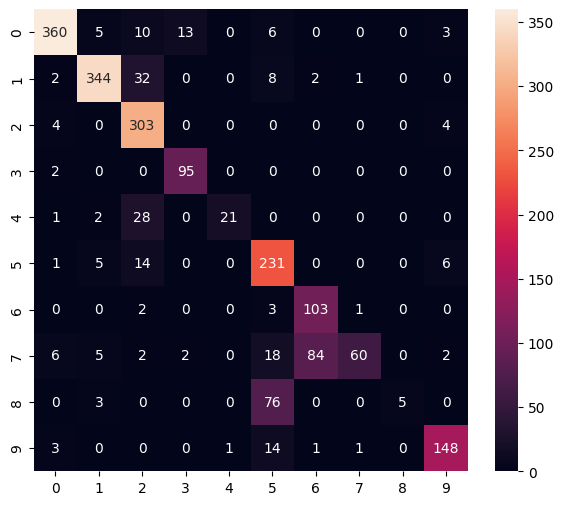

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       397
           1       0.95      0.88      0.91       389
           2       0.77      0.97      0.86       311
           3       0.86      0.98      0.92        97
           4       0.95      0.40      0.57        52
           5       0.65      0.90      0.75       257
           6       0.54      0.94      0.69       109
           7       0.95      0.34      0.50       179
           8       1.00      0.06      0.11        84
           9       0.91      0.88      0.89       168

    accuracy                           0.82      2043
   macro avg       0.85      0.73      0.71      2043
weighted avg       0.86      0.82      0.80      2043



In [279]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [280]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [281]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\nmosq\AppData\Local\Temp\tmpbwwitf0k\assets


INFO:tensorflow:Assets written to: C:\Users\nmosq\AppData\Local\Temp\tmpbwwitf0k\assets


6888

# Inference test

In [282]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [283]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [284]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [285]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1.58 ms


In [286]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[7.5657689e-03 5.6744598e-02 3.3963283e-03 2.2791997e-03 4.5660962e-04
 1.3464378e-01 5.4496354e-01 2.1607901e-01 2.6015554e-02 7.8555420e-03]
6
